In [3]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [2]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=332e79e0e1a2fc08519d8446e4ba1c158a8671df42b6ffadbc5b353289d4f771
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
dataset_dir = "/content/drive/MyDrive/Feynn_Labs_Internship/Portfolio_Managment"

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [165]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the stock ticker and the date range
ticker = 'QCOM'
start_date = '2010-01-01'
end_date = '2019-01-30'

# Download the data
data = yf.download(ticker, start=start_date, end=end_date)
data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,46.790001,47.310001,46.570000,46.939999,32.402744,14570200
2010-01-05,47.520000,48.320000,47.500000,48.070000,33.182770,24241000
2010-01-06,48.259998,48.430000,47.380001,47.599998,32.858330,22743800
2010-01-07,47.750000,49.020000,47.549999,48.980000,33.810955,25266300
2010-01-08,49.110001,49.799999,48.889999,49.470001,34.149200,25938200
...,...,...,...,...,...,...
2019-01-23,52.919998,53.570000,51.220001,51.770000,45.152538,33788600
2019-01-24,51.950001,51.980000,50.410000,50.810001,44.315258,32782700
2019-01-25,50.930000,52.029999,50.279999,51.299999,44.742615,19516200


In [166]:
## Simple Moving Average
data['SMA Close (F)']= ta.sma(data["Close"], length= 21)
data['SMA Close (M)']= ta.sma(data['Close'], length= 75)
data['SMA Close (S)']= ta.sma(data['Close'], length= 150)


## Exponential Moving Average
data['EMA Close (F)']= ta.ema(data["Close"], length= 21)
data['EMA Close (M)']= ta.ema(data['Close'], length= 75)
data['EMA Close (S)']= ta.ema(data['Close'], length= 150)


## Double Exponential Moving Average
data['DEMA Close (F)']= ta.dema(data["Close"], length= 21)
data['DEMA Close (M)']= ta.dema(data['Close'], length= 75)
data['DEMA Close (S)']= ta.dema(data['Close'], length= 150)


## Triple Exponential Movng Average
data['TEMA Close (F)']= ta.tema(data["Close"], length= 21)
data['TEMA Close (M)']= ta.tema(data['Close'], length= 75)
data['TEMA Close (S)']= ta.tema(data['Close'], length= 150)


## Kaufman Adaptive Moving Average
data['KAMA Close (F)']= ta.kama(data["Close"], length= 21)
data['KAMA Close (M)']= ta.kama(data['Close'], length= 75)
data['KAMA Close (S)']= ta.kama(data['Close'], length= 150)

## MACD
macdClose= ta.macd(data['Close'])

## Bollinger Bands
bbandsClose= ta.bbands(data['Close'])

## Momentum
data['Momentum Close']= ta.mom(data['Close'])

## Relative Strength Index
data['RSI Close']= ta.rsi(data['Close'], period= 14)

## True Range
data['TrueRange']= ta.true_range(data['High'], data['Low'], data['Close'])

## Avrerage True Range
data['AvgTrueRange']= ta.atr(data['High'], data['Low'], data['Close'])

In [167]:
## Simple Return
data['CloseR']= data['Close']/data['Close'].shift(-1) ## target feature we want to predict
data['OpenR']= data['Open']/data['Open'].shift(-1)
data['HighR']= data['High']/data['High'].shift(-1)
data['LowR']= data['Low']/data['Low'].shift(-1)

## Lagged Return Calculations
data['CloseR (2)']= data['Close']/data['Close'].shift(-2)
data['OpenR (2)']= data['Open']/data['Open'].shift(-2)
data['HighR (2)']= data['High']/data['High'].shift(-2)
data['LowR (2)']= data['Low']/data['Low'].shift(-2)

data['CloseR (3)']= data['Close']/data['Close'].shift(-3)
data['OpenR (3)']= data['Open']/data['Open'].shift(-3)
data['HighR (3)']= data['High']/data['High'].shift(-3)
data['LowR (3)']= data['Low']/data['Low'].shift(-3)

data['CloseR (2/3)']= data['Close'].shift(-2)/data['Close'].shift(-3)
data['OpenR (2/3)']= data['Open'].shift(-2)/data['Open'].shift(-3)
data['HighR (2/3)']= data['High'].shift(-2)/data['High'].shift(-3)
data['LowR (2/3)']= data['Low'].shift(-2)/data['Low'].shift(-3)


data['CloseR (4)']= data['Close']/data['Close'].shift(-4)
data['OpenR (4)']= data['Open']/data['Open'].shift(-4)
data['HighR (4)']= data['High']/data['High'].shift(-4)
data['LowR (4)']= data['Low']/data['Low'].shift(-4)

data['CloseR (5)']= data['Close']/data['Close'].shift(-5)
data['OpenR (5)']= data['Open']/data['Open'].shift(-5)
data['HighR (5)']= data['High']/data['High'].shift(-5)
data['LowR (5)']= data['Low']/data['Low'].shift(-5)

data['CloseR (4/5)']= data['Close'].shift(-4)/data['Close'].shift(-5)
data['OpenR (4/5)']= data['Open'].shift(-4)/data['Open'].shift(-5)
data['HighR (4/5)']= data['High'].shift(-4)/data['High'].shift(-5)
data['LowR (4/5)']= data['Low'].shift(-4)/data['Low'].shift(-5)

data['CloseR (15)']= data['Close']/data['Close'].shift(-15)
data['OpenR (15)']= data['Open']/data['Open'].shift(-15)
data['HighR (15)']= data['High']/data['High'].shift(-15)
data['LowR (15)']= data['Low']/data['Low'].shift(-15)

data['CloseR (30)']= data['Close']/data['Close'].shift(-30)
data['OpenR (30)']= data['Open']/data['Open'].shift(-30)
data['HighR (30)']= data['High']/data['High'].shift(-30)
data['LowR (30)']= data['Low']/data['Low'].shift(-30)

data['CloseR (15/30)']= data['Close'].shift(-15)/data['Close'].shift(-30)
data['OpenR (15/30)']= data['Open'].shift(-15)/data['Open'].shift(-30)
data['HighR (15/30)']= data['High'].shift(-15)/data['High'].shift(-30)
data['LowR (15/30)']= data['Low'].shift(-15)/data['Low'].shift(-30)

data['High/Open']= data['High']/data['Open']
data['Low/Open']= data['Low']/data['Open']
data['High/Close']= data['High']/data['Close']
data['Low/Close']= data['Low']/data['Close']

data['High/Open (1)']= data['High']/data['Open'].shift(-1)
data['Low/Open (1)']= data['Low']/data['Open'].shift(-1)
data['High/Close (1)']= data['High']/data['Close'].shift(-1)
data['Low/Close (1)']= data['Low']/data['Close'].shift(-1)

data['High/Open (2)']= data['High']/data['Open'].shift(-2)
data['Low/Open (2)']= data['Low']/data['Open'].shift(-2)
data['High/Close (2)']= data['High']/data['Close'].shift(-2)
data['Low/Close (2)']= data['Low']/data['Close'].shift(-2)

data['High/Open (1/2)']= data['High'].shift(-1)/data['Open'].shift(-2)
data['Low/Open (1/2)']= data['Low'].shift(-1)/data['Open'].shift(-2)
data['High/Close (1/2)']= data['High'].shift(-1)/data['Close'].shift(-2)
data['Low/Close (1/2)']= data['Low'].shift(-1)/data['Close'].shift(-2)

data['High/Open (3)']= data['High']/data['Open'].shift(-3)
data['Low/Open (3)']= data['Low']/data['Open'].shift(-3)
data['High/Close (3)']= data['High']/data['Close'].shift(-3)
data['Low/Close (3)']= data['Low']/data['Close'].shift(-3)

data['High/Open (2/3)']= data['High'].shift(-2)/data['Open'].shift(-3)
data['Low/Open (2/3)']= data['Low'].shift(-2)/data['Open'].shift(-3)
data['High/Close (2/3)']= data['High'].shift(-2)/data['Close'].shift(-3)
data['Low/Close (2/3)']= data['Low'].shift(-2)/data['Close'].shift(-3)

data['High/Open (15)']= data['High']/data['Open'].shift(-15)
data['Low/Open (15)']= data['Low']/data['Open'].shift(-15)
data['High/Close (15)']= data['High']/data['Close'].shift(-15)
data['Low/Close (15)']= data['Low']/data['Close'].shift(-15)

data['High/Open (30)']= data['High']/data['Open'].shift(-30)
data['Low/Open (30)']= data['Low']/data['Open'].shift(-30)
data['High/Close (30)']= data['High']/data['Close'].shift(30)
data['Low/Close (30)']= data['Low']/data['Close'].shift(30)

data['High/Open (15/30)']= data['High'].shift(-15)/data['Open'].shift(-30)
data['Low/Open (15/30)']= data['Low'].shift(-15)/data['Open'].shift(-30)
data['High/Close (15/30)']= data['High'].shift(15)/data['Close'].shift(-30)
data['Low/Close (15/30)']= data['Low'].shift(-15)/data['Close'].shift(-30)

data['High/Open (30/30)']= data['High'].shift(-30)/data['Open'].shift(-30)
data['Low/Open (30/30)']= data['Low'].shift(-30)/data['Open'].shift(-30)
data['High/Close (30/30)']= data['High'].shift(-30)/data['Close'].shift(-30)
data['Low/Close (30/30)']= data['Low'].shift(-30)/data['Close'].shift(-30)

data['High/Open (35/35)']= data['High'].shift(-35)/data['Open'].shift(35)
data['Low/Open (35/35)']= data['Low'].shift(-35)/data['Open'].shift(-35)
data['High/Close (35/35)']= data['High'].shift(-35)/data['Close'].shift(-35)
data['Low/Close (35/35)']= data['Low'].shift(-35)/data['Close'].shift(-35)

data['High/Open (35/35)']= data['High'].shift(-35)/data['Open'].shift(35)
data['Low/Open (35/35)']= data['Low'].shift(-35)/data['Open'].shift(-35)
data['High/Close (35/35)']= data['High'].shift(-35)/data['Close'].shift(-35)
data['Low/Close (35/35)']= data['Low'].shift(-35)/data['Close'].shift(-35)

data['High/Open (37/40)']= data['High'].shift(-37)/data['Open'].shift(-40)
data['Low/Open (37/40)']= data['Low'].shift(-37)/data['Open'].shift(-40)
data['High/Close (37/40)']= data['High'].shift(-37)/data['Close'].shift(-40)
data['Low/Close (37/40)']= data['Low'].shift(-37)/data['Close'].shift(-40)

data['High/Open (39/40)']= data['High'].shift(-39)/data['Open'].shift(-40)
data['Low/Open (39/40)']= data['Low'].shift(-39)/data['Open'].shift(-40)
data['High/Close (39/40)']= data['High'].shift(-39)/data['Close'].shift(-40)
data['Low/Close (39/40)']= data['Low'].shift(-39)/data['Close'].shift(-40)

data['High/Open (38/40)']= data['High'].shift(-38)/data['Open'].shift(-40)
data['Low/Open (38/40)']= data['Low'].shift(-38)/data['Open'].shift(-40)
data['High/Close (38/40)']= data['High'].shift(-38)/data['Close'].shift(-40)
data['Low/Close (38/40)']= data['Low'].shift(-38)/data['Close'].shift(-40)

data['High/Open (40/40)']= data['High'].shift(-40)/data['Open'].shift(-40)
data['Low/Open (40/40)']= data['Low'].shift(-40)/data['Open'].shift(-40)
data['High/Close (40/40)']= data['High'].shift(-40)/data['Close'].shift(-40)
data['Low/Close (40/40)']= data['Low'].shift(-40)/data['Close'].shift(-40)

## Lagging Calculated Returns
data['RetClose']= data['CloseR'].shift(-1)
data['RetClose (2)']= data['CloseR'].shift(-2)
data['RetClose (3)']= data['CloseR'].shift(-3)
data['RetClose (5)']= data['CloseR'].shift(-5)
data['RetClose (6)']= data['CloseR'].shift(-6)
data['RetClose (15)']= data['CloseR'].shift(-15)
data['RetClose (20)']= data['CloseR'].shift(-20)
data['RetClose (30)']= data['CloseR'].shift(-30)
data['RetClose (35)']= data['CloseR'].shift(-35)
data['RetClose (40)']= data['CloseR'].shift(-40)


data['RetLow']= data['LowR'].shift(-1)
data['RetLow (2)']= data['LowR'].shift(-2)
data['RetLow (3)']= data['LowR'].shift(-3)
data['RetLow (5)']= data['LowR'].shift(-5)
data['RetLow (6)']= data['LowR'].shift(-6)
data['RetLow (15)']= data['LowR'].shift(-15)
data['RetLow (20)']= data['LowR'].shift(-20)
data['RetLow (30)']= data['LowR'].shift(-30)
data['RetLow (35)']= data['LowR'].shift(-35)
data['RetLow (40)']= data['LowR'].shift(-40)


data['RetHigh']= data['HighR'].shift(-1)
data['RetHigh (2)']= data['HighR'].shift(-2)
data['RetHigh (3)']= data['HighR'].shift(-3)
data['RetHigh (5)']= data['HighR'].shift(-5)
data['RetHigh (6)']= data['HighR'].shift(-6)
data['RetHigh (15)']= data['HighR'].shift(-15)
data['RetHigh (20)']= data['HighR'].shift(-20)
data['RetHigh (30)']= data['HighR'].shift(-30)
data['RetHigh (35)']= data['HighR'].shift(-35)
data['RetHigh (40)']= data['HighR'].shift(-40)


data['RetLow']= data['LowR'].shift(-1)
data['RetLow (2)']= data['LowR'].shift(-2)
data['RetLow (3)']= data['LowR'].shift(-3)
data['RetLow (5)']= data['LowR'].shift(-5)
data['RetLow (6)']= data['LowR'].shift(-6)
data['RetLow (15)']= data['LowR'].shift(-15)
data['RetLow (20)']= data['LowR'].shift(-20)
data['RetLow (30)']= data['LowR'].shift(-30)
data['RetLow (35)']= data['LowR'].shift(-35)
data['RetLow (40)']= data['LowR'].shift(-40)

data['RetOpen']= data['OpenR'].shift(-1)
data['RetOpen (2)']= data['OpenR'].shift(-2)
data['RetOpen (3)']= data['OpenR'].shift(-3)
data['RetOpen (5)']= data['OpenR'].shift(-5)
data['RetOpen (6)']= data['OpenR'].shift(-6)
data['RetOpen (15)']= data['OpenR'].shift(-15)
data['RetOpen (20)']= data['OpenR'].shift(-20)
data['RetOpen (30)']= data['OpenR'].shift(-30)
data['RetOpen (35)']= data['OpenR'].shift(-35)
data['RetOpen (40)']= data['OpenR'].shift(-40)

<ipython-input-167-565802aefaf0>:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Low/Close (30/30)']= data['Low'].shift(-30)/data['Close'].shift(-30)
<ipython-input-167-565802aefaf0>:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['High/Open (35/35)']= data['High'].shift(-35)/data['Open'].shift(35)
<ipython-input-167-565802aefaf0>:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [168]:
data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis= 1, inplace= True)
data.dropna(inplace= True)
data.reset_index(inplace= True)
data['TargetCloseR']= data['CloseR'].shift(-30).fillna(0)

print('CloseR Column:', data.columns.get_loc('CloseR'))
print('DataFrame Shape:', data.shape)
data

CloseR Column: 20
DataFrame Shape: (2093, 161)


<ipython-input-168-454ef8da3431>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.reset_index(inplace= True)
<ipython-input-168-454ef8da3431>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['TargetCloseR']= data['CloseR'].shift(-30).fillna(0)


,Date,SMA Close (F),SMA Close (M),SMA Close (S),EMA Close (F),EMA Close (M),EMA Close (S),DEMA Close (F),DEMA Close (M),DEMA Close (S),...,RetOpen (2),RetOpen (3),RetOpen (5),RetOpen (6),RetOpen (15),RetOpen (20),RetOpen (30),RetOpen (35),RetOpen (40),TargetCloseR
0,2010-08-06,37.592857,36.393867,39.116067,37.617580,37.239752,39.116067,38.814595,36.090313,39.116067,...,1.007653,1.036215,1.003168,0.972279,1.002865,1.004238,0.985420,0.991721,1.000225,0.988508
1,2010-08-09,37.870953,36.399467,39.068133,37.811436,37.305812,39.124463,39.075865,36.250941,39.132748,...,1.036215,0.995526,0.972279,0.996419,1.005500,0.986959,0.992193,1.021252,1.004750,1.004850
2,2010-08-10,38.093810,36.419867,39.012867,37.990397,37.370922,39.133146,39.302568,36.407208,39.149889,...,0.995526,1.003168,0.996419,1.009032,0.979979,0.987366,1.013970,0.970934,0.984413,0.991982
3,2010-08-11,38.256191,36.436533,38.957933,38.114906,37.423266,39.136150,39.420980,36.535880,39.155637,...,1.003168,0.972279,1.009032,1.016793,0.981607,1.003413,0.977247,0.990332,1.009667,0.979798
4,2010-08-12,38.320000,36.440800,38.886333,38.126278,37.444759,39.124281,39.323957,36.601652,39.131797,...,0.972279,0.996419,1.016793,0.972442,0.985353,1.001954,0.991652,1.024308,0.995747,0.999103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,2018-11-20,59.939047,66.604267,62.033000,59.321328,63.656031,63.122128,54.997222,63.045784,64.871504,...,0.981717,1.003598,0.965452,0.994332,1.010076,1.017064,0.994357,0.994766,1.038738,0.000000
2089,2018-11-21,59.410000,66.468666,62.058533,58.953026,63.435346,63.018126,54.687200,62.626280,64.641708,...,1.003598,0.994632,0.994332,0.962155,0.999479,1.047672,1.007999,1.028161,1.018672,0.000000
2090,2018-11-23,59.059048,66.336533,62.090000,58.616387,63.219943,62.915237,54.432328,62.222432,64.415788,...,0.994632,0.965452,0.962155,1.025767,0.998267,0.989862,1.001246,1.014190,1.020027,0.000000
2091,2018-11-26,58.703333,66.211866,62.128600,58.353988,63.022839,62.820068,54.311754,61.859662,64.206836,...,0.965452,0.994332,1.025767,1.053205,1.002607,0.976773,0.995042,0.992417,1.012122,0.000000


In [169]:
data.drop(columns = ['Date'], inplace = True)

In [170]:
# Standardize returns
scaler = MinMaxScaler(feature_range= (0,1))
# scaler = StandardScaler()
data.iloc[:,:-1] = scaler.fit_transform(data.iloc[:,:-1])

In [171]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_selection import RFE
# from sklearn.metrics import accuracy_score, mean_squared_error
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import utils
# import math

# ## Data Preparation for RFE
# X_rfe= data.iloc[:,:-1]
# y_rfe= data['TargetCloseR']

# xr_train, xr_test, yr_train, yr_test= train_test_split(X_rfe, y_rfe, test_size= 0.2, random_state= 0)

# ## Defining a RandomForest regression function to check the accuracy the RFE selected features
# def run_RF(xr_train, xr_test, yr_train, yr_test):
#     clf= RandomForestRegressor(n_estimators= 500, random_state= 0, n_jobs= -1)
#     clf.fit(xr_train, yr_train)
#     yr_pred= clf.predict(xr_test)
#     print('Loss:', math.sqrt(mean_squared_error(yr_test, yr_pred)))

# ## Defining the RandomForest RFE Algorithm (25 features will be selected)
# rfe= RFE(RandomForestRegressor(n_estimators= 500, random_state= 1, n_jobs= -1), n_features_to_select= 25, verbose= 1)
# rfe.fit(xr_train, yr_train)
# xr1_train= rfe.transform(xr_train)
# xr1_test= rfe.transform(xr_test)
# print('Selected Features:', 25)
# run_RF(xr1_train, xr1_test, yr_train, yr_test)
# print()

In [172]:
# selected_index = np.where(rfe.support_ == True)
# for i in selected_index:
#   print(X_rfe.columns[i])
# print(f'Number of selected features : {len(selected_index[0])}')

In [173]:
selected= ['EMA Close (F)', 'EMA Close (M)', 'EMA Close (S)', 'DEMA Close (F)',
       'DEMA Close (M)', 'TEMA Close (S)', 'KAMA Close (F)', 'TrueRange',
       'CloseR (5)', 'HighR (30)', 'Low/Open', 'High/Open (1)',
       'High/Open (3)', 'High/Close (30)', 'Low/Close (30)',
       'Low/Close (35/35)', 'High/Close (40/40)', 'RetClose (30)',
       'RetClose (40)', 'RetLow (30)', 'RetLow (35)', 'RetHigh (30)',
       'RetHigh (40)', 'RetOpen (15)', 'RetOpen (35)']
newdata= data[selected]
newdata

,EMA Close (F),EMA Close (M),EMA Close (S),DEMA Close (F),DEMA Close (M),TEMA Close (S),KAMA Close (F),TrueRange,CloseR (5),HighR (30),...,Low/Close (35/35),High/Close (40/40),RetClose (30),RetClose (40),RetLow (30),RetLow (35),RetHigh (30),RetHigh (40),RetOpen (15),RetOpen (35)
0,0.000000,0.000000,0.002458,0.000443,0.000000,0.006138,0.000000,0.069656,0.526538,0.234730,...,0.917923,0.109467,0.345980,0.356680,0.348040,0.416285,0.476578,0.503436,0.587820,0.545391
1,0.004579,0.001576,0.002678,0.006693,0.003582,0.006721,0.006605,0.094465,0.550851,0.245139,...,0.931719,0.128654,0.401808,0.355399,0.414876,0.385874,0.552654,0.561792,0.597852,0.657822
2,0.008806,0.003130,0.002906,0.012117,0.007066,0.007316,0.011426,0.059160,0.521586,0.251479,...,0.888037,0.005978,0.357846,0.392908,0.381636,0.313686,0.544857,0.519512,0.500691,0.466253
3,0.011747,0.004379,0.002984,0.014949,0.009935,0.007509,0.013547,0.099237,0.502302,0.230023,...,0.935124,0.081882,0.316223,0.369211,0.310123,0.444329,0.439424,0.547344,0.506889,0.540103
4,0.012016,0.004891,0.002673,0.012628,0.011402,0.006667,0.013589,0.120229,0.490985,0.166110,...,0.937524,0.029817,0.382175,0.430089,0.366714,0.425589,0.540596,0.560935,0.521147,0.669455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,0.512663,0.630289,0.631677,0.387569,0.601065,0.609744,0.485025,0.101145,0.410701,0.347900,...,0.868000,0.114718,0.415159,0.551534,0.404341,0.429908,0.561787,0.643623,0.615274,0.556986
2089,0.503963,0.625023,0.628951,0.380152,0.591711,0.601449,0.476067,0.122138,0.367345,0.388759,...,0.975192,0.309348,0.345410,0.449787,0.357359,0.407777,0.527854,0.659096,0.574928,0.684126
2090,0.496012,0.619884,0.626254,0.374055,0.582706,0.593348,0.470630,0.066794,0.360742,0.359078,...,0.983814,0.204875,0.373812,0.352608,0.388028,0.429761,0.551107,0.539480,0.570312,0.630933
2091,0.489814,0.615181,0.623759,0.371171,0.574616,0.585895,0.466804,0.085878,0.346565,0.381790,...,0.940603,0.126607,0.343649,0.429765,0.373541,0.351819,0.466214,0.597824,0.586836,0.548044


In [174]:
from sklearn.neural_network import BernoulliRBM

# Apply RBM to the lagged returns
rbm = BernoulliRBM(n_components=100, learning_rate=0.005, n_iter=20, random_state=10)
rbm_pipeline = Pipeline(steps=[('rbm', rbm)])

okk = rbm_pipeline.fit_transform(newdata)

In [175]:
sc = MinMaxScaler(feature_range= (0,1))
# sc = StandardScaler()
newdata = sc.fit_transform(newdata)

In [176]:
newdata

array([[0.        , 0.        , 0.002458  , ..., 0.50343648, 0.58782041,
        0.54539139],
       [0.00457907, 0.00157616, 0.00267808, ..., 0.56179189, 0.59785182,
        0.65782216],
       [0.00880628, 0.00312968, 0.00290566, ..., 0.51951187, 0.50069069,
        0.46625345],
       ...,
       [0.49601171, 0.61988391, 0.62625394, ..., 0.53948009, 0.57031241,
        0.63093323],
       [0.4898136 , 0.61518104, 0.62375949, ..., 0.59782422, 0.58683625,
        0.54804372],
       [0.48383537, 0.61050146, 0.62124253, ..., 0.57668202, 0.59820287,
        0.6060001 ]])

In [177]:
## Scaling the target data
TargetReturns= data['TargetCloseR'][:len(data)-30].values.reshape(-1,1)
scaler2= MinMaxScaler(feature_range= (0,1))
# scaler2 = StandardScaler()
scaled2= scaler2.fit_transform(TargetReturns)

print('Scaled Data Shape:', np.shape(scaled2))
print('Scaled Length:', len(scaled2))
print('Scaled Data Dimensions:', scaled2.ndim)
scaled2

Scaled Data Shape: (2063, 1)
Scaled Length: 2063
Scaled Data Dimensions: 2


array([[0.34598047],
       [0.40180792],
       [0.35784609],
       ...,
       [0.35581487],
       [0.3950757 ],
       [0.32010931]])

In [178]:
## Creating a time series dataset for LSTM
days= 72
X= []

for j in range(25):
    X.append([])
    for i in range(days, len(newdata)):
        X[j].append(newdata[i-days:i, j])

X, yi= np.array(X), np.array(scaled2[days:, 0])
X= np.moveaxis(X, [0], [2])
y= np.reshape(yi, (len(yi), 1))


In [179]:
## Splitting data (80% training, 20% testing)
split= int(len(X)* 0.8)

x_train, x_test= X[:split], X[split:]
y_train, y_test= y[:split], y[split:]

print('x_train Shape:', np.shape(x_train))
print('x_train Dimensions:', x_train.ndim)
print()
print('x_test Shape:', np.shape(x_test))
print('x_test Dimensions:', x_test.ndim)
print()
print('y_train Shape:', np.shape(y_train))
print('y_train Dimensions:', y_train.ndim)
print()
print('y_test Shape:', np.shape(y_test))
print('y_test Dimensions:', y_test.ndim)

x_train Shape: (1616, 72, 25)
x_train Dimensions: 3

x_test Shape: (405, 72, 25)
x_test Dimensions: 3

y_train Shape: (1616, 1)
y_train Dimensions: 2

y_test Shape: (375, 1)
y_test Dimensions: 2


In [140]:
## Hyperparameter Tuning
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 3)):
        model.add(LSTM(units=hp.Int('units_' + str(i), 10, 200, step=10),
                       return_sequences=hp.Choice('ret_' + str(i), [True, False]),
                       input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.1))
    model.add(Dense(units=1, activation=hp.Choice('act_1', ['relu', 'sigmoid'])))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

tuner = RandomSearch(build_model, objective='loss', max_trials=2, executions_per_trial=2)

tuner.search_space_summary()

Search space summary
Default search space size: 6
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
ret_0 (Choice)
{'default': 1, 'conditions': [], 'values': [1, 0], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
ret_1 (Choice)
{'default': 1, 'conditions': [], 'values': [1, 0], 'ordered': True}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
tuner.search(x_train, y_train, epochs= 37, batch_size= 32,
             validation_data= (x_test, y_test), validation_split= 0.2)

In [ ]:
model= Sequential()
model.add(LSTM(units= 120, return_sequences= True, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units= 170, return_sequences= True, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units= 50, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(units= 1, activation= 'relu'))

es= EarlyStopping(monitor= 'loss', min_delta= 1e-10, patience= 10, verbose= 1)
rlr= ReduceLROnPlateau(monitor= 'loss', factor= 0.5, patience= 10, verbose= 1)

model.compile(tf.keras.optimizers.Adam(learning_rate= 0.001), loss= 'mean_squared_error')
model.fit(x_train, y_train, epochs= 100, batch_size= 32, callbacks= [es, rlr], validation_split= 0.2, shuffle= True)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0374 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0042 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0043 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0042 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 10/100
41/41 ━━━

Text(0.5, 1.0, 'Plot of Mean Sqaured Error per Increasing Epochs')

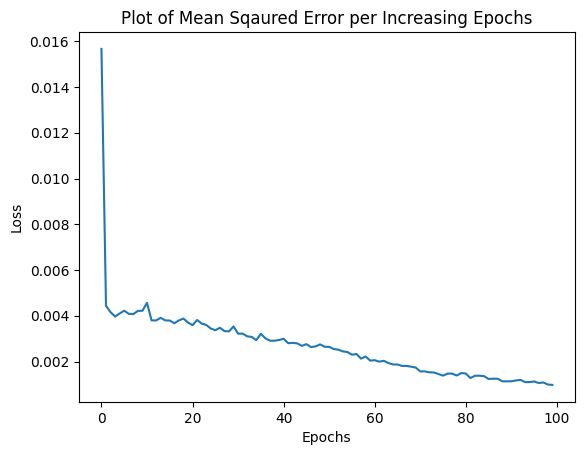

In [ ]:
loss= model.history.history['loss']
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Mean Sqaured Error per Increasing Epochs')

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 72, 120)             │          70,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 72, 120)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 72, 170)             │         197,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 72, 170)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 50)                  │          44,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 936,635 (3.57 MB)

 Trainable params: 312,211 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 624,424 (2.38 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


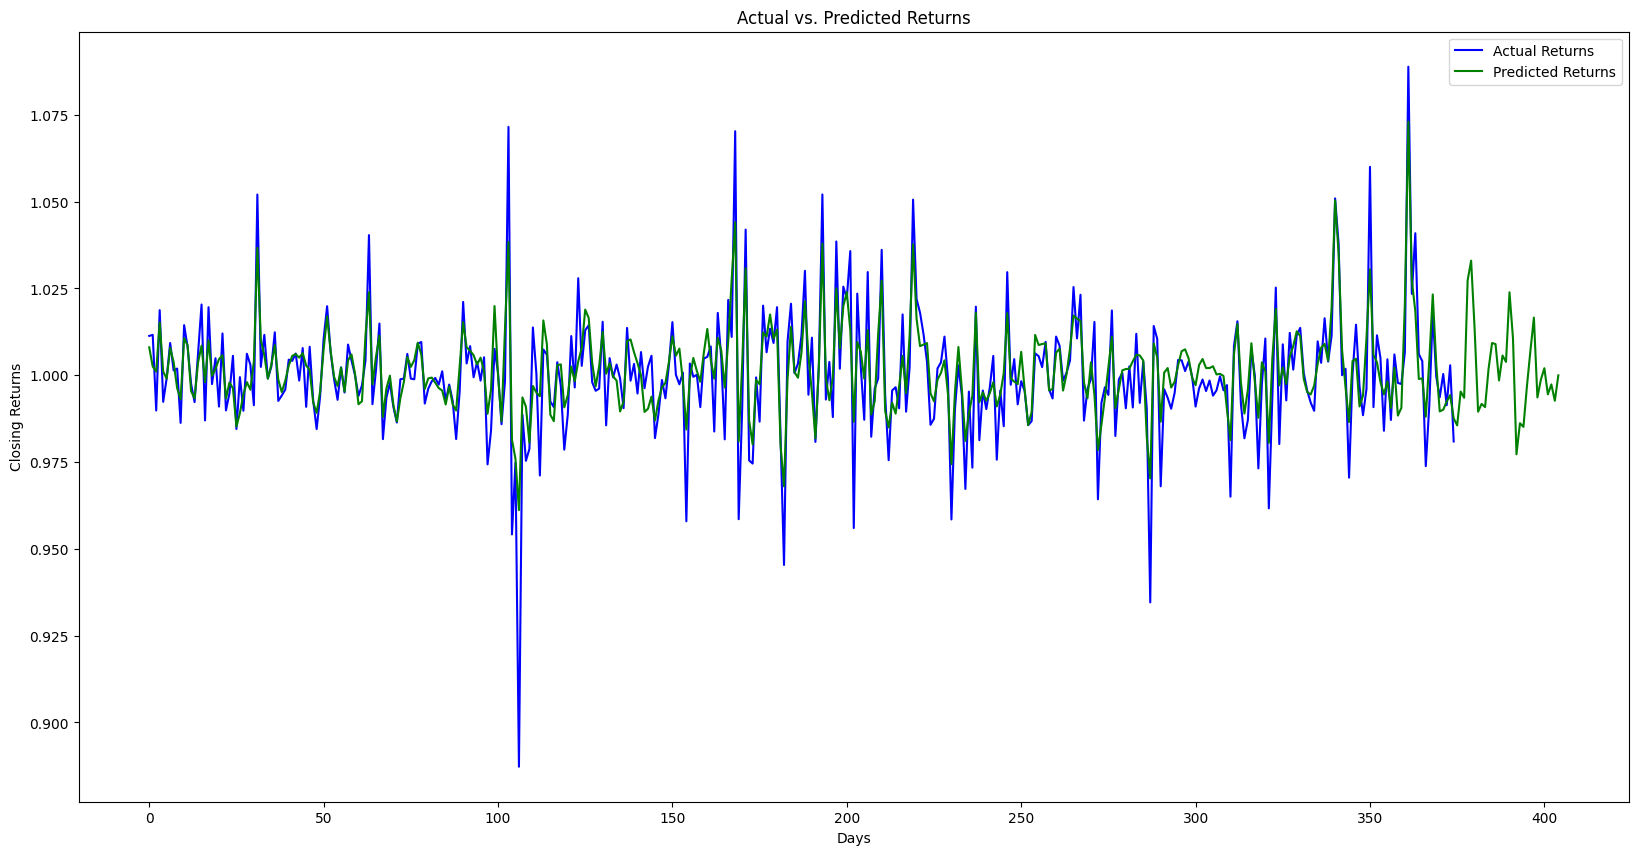

In [ ]:
## Predicting the test data
test_predict= model.predict(x_test)

## Getting actual test values
test_predict= scaler2.inverse_transform(test_predict)
returnss= scaler2.inverse_transform(y_test)

## Plotting the predictions
plt.figure(figsize= (20,10))
plt.plot(returnss, color= 'blue', label= 'Actual Returns')
plt.plot(test_predict[:], color= 'green', label= 'Predicted Returns')

plt.xlabel('Days')
plt.ylabel('Closing Returns')
plt.title('Actual vs. Predicted Returns')
plt.legend()

In [ ]:
# Save the entire model
import os
file_path = os.path.join(dataset_dir, "Qualcomm_model.keras")
model.save(file_path)

In [ ]:
#test the best model
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics
mse = mean_squared_error(returnss, test_predict[:len(returnss)])
r2 = r2_score(returnss, test_predict[:len(returnss)])

# Print the metrics
print(f'Mean Squared Error (MSE) on test data: {mse}')
print(f'R^2 Score on test data: {r2}')

Mean Squared Error (MSE) on test data: 9.495769700724124e-05
R^2 Score on test data: 0.7092769578678766


In [180]:
import os
from tensorflow.keras.models import load_model
file_path = os.path.join(dataset_dir, "Qualcomm_model.keras")
# Load the saved model
model = load_model(file_path)

In [181]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 72, 120)             │          70,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 72, 120)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 72, 170)             │         197,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 72, 170)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 50)                  │          44,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 936,635 (3.57 MB)

 Trainable params: 312,211 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 624,424 (2.38 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step


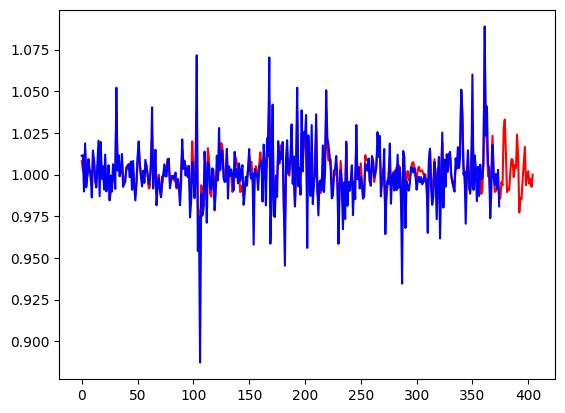

In [182]:
plt.plot(scaler2.inverse_transform(model.predict(x_test)), color = 'red')
plt.plot(scaler2.inverse_transform(y_test), color = 'blue')
plt.show()

In [101]:
ALB = pd.Series(predictions_flat)

In [124]:
F = pd.Series(scaler2.inverse_transform(model.predict(x_test)).flatten())

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


In [145]:
GM =pd.Series(scaler2.inverse_transform(model.predict(x_test)).flatten())

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


In [164]:
NVDA = pd.Series(scaler2.inverse_transform(model.predict(x_test)).flatten())

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [183]:
QCOM = pd.Series(scaler2.inverse_transform(model.predict(x_test)).flatten())

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


In [192]:
import pandas as pd

# Assuming F, GM, NVDA, ALB, and QCOM are defined data
returns = pd.DataFrame([F, GM, NVDA, ALB, QCOM])
returns = returns.transpose()

In [196]:
returns.columns = ['F','GM','NVDA','ALB','QCOM']
returns.dropna(inplace = True)

In [197]:
returns

,F,GM,NVDA,ALB,QCOM
0,1.009822,1.005119,1.007137,1.007184,1.008045
1,0.996025,1.007913,0.973325,0.998977,1.002532
2,0.993239,0.992910,0.956990,0.983833,1.001055
3,0.990402,0.986645,1.025692,0.999298,1.015203
4,0.989471,0.991534,1.003349,1.028156,1.001085
...,...,...,...,...,...
355,0.994253,0.977529,0.970743,0.976660,0.998230
356,1.014407,1.002718,0.985963,0.958665,0.990599
357,0.986442,1.000216,0.999665,0.992890,1.002174
358,0.984159,0.944142,0.989018,1.005136,0.988392


In [201]:
returns.to_csv('returns.csv', index=False)